In [1]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [2]:
import cactas as C
import tensorflow as tf
import pickle

2024-06-19 01:28:45.485898: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


In [3]:
DATAPATH='/raid/mpsych/CACTAS/DATA/ESUS'
CAPATH='/raid/mpsych/CACTAS/DATA/CA24'

In [4]:
images, labels = C.Helper.load_data(DATAPATH)

In [5]:
masks = C.Helper.load_seg_data(CAPATH)

In [6]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.split_patients_masks(images, labels, masks)

In [7]:
with open('/raid/mpsych/CACTAS/DATA/HISTORY/unet_30/train_patient_order.pkl', 'wb') as f:
    pickle.dump(X_train, f)
with open('/raid/mpsych/CACTAS/DATA/HISTORY/unet_30/test_patient_order.pkl', 'wb') as f:
    pickle.dump(X_test, f)

In [8]:
X_train, y_train, m_train, X_test, y_test, m_test = C.Helper.normalization2(DATAPATH, CAPATH, X_train, y_train, m_train, X_test, y_test, m_test)

In [9]:
slice_to_patient_mapping, last_key = C.Helper.map_and_key_fulldata(y_train)

10335


In [10]:
X_train, y_train, X_test, y_test = C.Helper.extract_slices(X_train, y_train, X_test, y_test)

(13418, 512, 512, 1) (13418, 512, 512, 1) (3348, 512, 512, 1) (3348, 512, 512, 1)


In [11]:
m_train, m_test = C.Helper.extract_masks_slices(m_train, m_test)

(13418, 512, 512, 1) (3348, 512, 512, 1)


In [12]:
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)
m_train = m_train.astype(np.float32)
m_test = m_test.astype(np.float32)

In [13]:
train_images_array, test_images_array = C.Helper.masked_image(X_train, m_train, X_test, m_test)

(13418, 512, 512, 1) (3348, 512, 512, 1)


In [14]:
from sklearn.model_selection import KFold

In [15]:
n_samples = len(train_images_array)
#kf = KFold(n_splits=n_samples // 100)
kf = KFold(n_splits=2, shuffle=False)
histories = []
fold = 1

In [16]:
kf

KFold(n_splits=2, random_state=None, shuffle=False)

In [17]:
losses = []
ious = []
iou_thresholds = []

In [18]:
for train_index, test_index in kf.split(train_images_array):
    X_train, X_val = train_images_array[train_index], train_images_array[test_index]
    Y_train, Y_val = y_train[train_index], y_train[test_index]

    model = C.Helper.create_unet(train_images_array[0].shape)

    print(f"Training fold {fold}...")
    history = model.fit(X_train, Y_train, 
                        epochs=100, 
                        batch_size=16, 
                        steps_per_epoch=len(X_train) // 16, 
                        validation_data=(X_val, Y_val))
    histories.append(history.history)
    
    scores = model.evaluate(test_images_array, y_test, verbose=0)
    losses.append(scores[0])
    ious.append(scores[1])
    iou_thresholds.append(scores[2])    
    
    fold += 1

-----------------------------------------
keras-unet init: TF version is >= 2.0.0 - using `tf.keras` instead of `Keras`
-----------------------------------------


2024-06-19 01:32:08.675751: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2024-06-19 01:32:08.879043: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-06-19 01:32:08.881656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-06-19 01:32:08.881679: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2024-06-19 01:32:08.885120: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-06-19 

Training fold 1...


2024-06-19 01:32:08.916568: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-19 01:32:09.108380: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:47:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-06-19 01:32:09.110893: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:4e:00.0 name: A100-SXM4-40GB computeCapability: 8.0
coreClock: 1.41GHz coreCount: 108 deviceMemorySize: 39.59GiB deviceMemoryBandwidth: 1.41TiB/s
2024-06-19 01:32:09.120798: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1871] Adding visible 

Epoch 1/100


2024-06-19 01:32:12.431668: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudnn.so.8
2024-06-19 01:32:13.119241: I tensorflow/stream_executor/cuda/cuda_dnn.cc:359] Loaded cuDNN version 8201
2024-06-19 01:32:13.765208: W tensorflow/stream_executor/gpu/asm_compiler.cc:191] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.0
2024-06-19 01:32:13.765233: W tensorflow/stream_executor/gpu/asm_compiler.cc:194] Used ptxas at ptxas
2024-06-19 01:32:13.765291: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] Unimplemented: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-06-19 01:32:13.843306: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2024-06-19 01:32:14.544050: I tensorflow/stream_exec

419/419 [==============================] - 242s 550ms/step - loss: 0.1360 - iou: 2.2981e-05 - iou_thresholded: 0.2454 - val_loss: 0.0079 - val_iou: 4.3426e-05 - val_iou_thresholded: 0.8899
Epoch 2/100
419/419 [==============================] - 228s 538ms/step - loss: 0.0042 - iou: 9.3510e-05 - iou_thresholded: 0.4776 - val_loss: 0.0020 - val_iou: 1.4740e-04 - val_iou_thresholded: 0.7845
Epoch 3/100
419/419 [==============================] - 225s 538ms/step - loss: 0.0013 - iou: 3.8488e-04 - iou_thresholded: 0.4416 - val_loss: 9.1815e-04 - val_iou: 5.9555e-04 - val_iou_thresholded: 0.7962
Epoch 4/100
419/419 [==============================] - 225s 538ms/step - loss: 6.7922e-04 - iou: 7.5217e-04 - iou_thresholded: 0.4415 - val_loss: 4.8929e-04 - val_iou: 7.7823e-04 - val_iou_thresholded: 0.8401
Epoch 5/100
419/419 [==============================] - 225s 538ms/step - loss: 4.1120e-04 - iou: 0.0015 - iou_thresholded: 0.4443 - val_loss: 3.1022e-04 - val_iou: 0.0010 - val_iou_thresholded: 0.

419/419 [==============================] - 226s 538ms/step - loss: 1.3763e-05 - iou: 0.3327 - iou_thresholded: 0.7020 - val_loss: 2.6566e-05 - val_iou: 0.4317 - val_iou_thresholded: 0.8029
Epoch 42/100
419/419 [==============================] - 225s 538ms/step - loss: 1.2889e-05 - iou: 0.3622 - iou_thresholded: 0.7209 - val_loss: 3.9410e-05 - val_iou: 0.5246 - val_iou_thresholded: 0.8749
Epoch 43/100
419/419 [==============================] - 226s 539ms/step - loss: 1.1080e-05 - iou: 0.3881 - iou_thresholded: 0.7608 - val_loss: 2.7885e-05 - val_iou: 0.4954 - val_iou_thresholded: 0.8571
Epoch 44/100
419/419 [==============================] - 225s 538ms/step - loss: 1.4979e-05 - iou: 0.3306 - iou_thresholded: 0.6932 - val_loss: 3.1253e-05 - val_iou: 0.5053 - val_iou_thresholded: 0.8342
Epoch 45/100
419/419 [==============================] - 225s 538ms/step - loss: 1.0994e-05 - iou: 0.3887 - iou_thresholded: 0.7493 - val_loss: 3.5043e-05 - val_iou: 0.5313 - val_iou_thresholded: 0.8203
Epo

Epoch 82/100
419/419 [==============================] - 225s 538ms/step - loss: 4.7496e-06 - iou: 0.7159 - iou_thresholded: 0.8756 - val_loss: 4.2093e-05 - val_iou: 0.6843 - val_iou_thresholded: 0.8202
Epoch 83/100
419/419 [==============================] - 225s 538ms/step - loss: 3.5829e-06 - iou: 0.7630 - iou_thresholded: 0.9045 - val_loss: 4.4444e-05 - val_iou: 0.7081 - val_iou_thresholded: 0.8272
Epoch 84/100
419/419 [==============================] - 225s 538ms/step - loss: 5.2825e-06 - iou: 0.7352 - iou_thresholded: 0.8718 - val_loss: 4.7153e-05 - val_iou: 0.7308 - val_iou_thresholded: 0.8554
Epoch 85/100
419/419 [==============================] - 225s 538ms/step - loss: 4.6580e-06 - iou: 0.7113 - iou_thresholded: 0.8727 - val_loss: 4.2809e-05 - val_iou: 0.7004 - val_iou_thresholded: 0.8133
Epoch 86/100
419/419 [==============================] - 226s 539ms/step - loss: 3.9887e-06 - iou: 0.7777 - iou_thresholded: 0.8960 - val_loss: 4.5801e-05 - val_iou: 0.7139 - val_iou_thresholde

419/419 [==============================] - 225s 538ms/step - loss: 3.1330e-05 - iou: 0.0886 - iou_thresholded: 0.4833 - val_loss: 4.5885e-05 - val_iou: 0.0782 - val_iou_thresholded: 0.7935
Epoch 23/100
419/419 [==============================] - 225s 538ms/step - loss: 2.7060e-05 - iou: 0.1074 - iou_thresholded: 0.5152 - val_loss: 3.8348e-05 - val_iou: 0.0846 - val_iou_thresholded: 0.8529
Epoch 24/100
419/419 [==============================] - 225s 538ms/step - loss: 2.6816e-05 - iou: 0.1169 - iou_thresholded: 0.5088 - val_loss: 4.0934e-05 - val_iou: 0.1023 - val_iou_thresholded: 0.8313
Epoch 25/100
419/419 [==============================] - 225s 538ms/step - loss: 2.7375e-05 - iou: 0.1132 - iou_thresholded: 0.4794 - val_loss: 4.2571e-05 - val_iou: 0.1147 - val_iou_thresholded: 0.8010
Epoch 26/100
419/419 [==============================] - 225s 538ms/step - loss: 2.3491e-05 - iou: 0.1513 - iou_thresholded: 0.5330 - val_loss: 3.9542e-05 - val_iou: 0.1259 - val_iou_thresholded: 0.8262
Epo

Epoch 63/100
419/419 [==============================] - 225s 537ms/step - loss: 6.5663e-06 - iou: 0.5641 - iou_thresholded: 0.7957 - val_loss: 4.9265e-05 - val_iou: 0.6086 - val_iou_thresholded: 0.8833
Epoch 64/100
419/419 [==============================] - 225s 537ms/step - loss: 6.0938e-06 - iou: 0.5469 - iou_thresholded: 0.7976 - val_loss: 4.7085e-05 - val_iou: 0.5409 - val_iou_thresholded: 0.8647
Epoch 65/100
419/419 [==============================] - 225s 537ms/step - loss: 5.6772e-06 - iou: 0.5911 - iou_thresholded: 0.8118 - val_loss: 5.2122e-05 - val_iou: 0.6541 - val_iou_thresholded: 0.8780
Epoch 66/100
419/419 [==============================] - 225s 537ms/step - loss: 4.9978e-06 - iou: 0.6083 - iou_thresholded: 0.8288 - val_loss: 4.5730e-05 - val_iou: 0.6487 - val_iou_thresholded: 0.8722
Epoch 67/100
419/419 [==============================] - 225s 538ms/step - loss: 5.2330e-06 - iou: 0.6314 - iou_thresholded: 0.8430 - val_loss: 5.2423e-05 - val_iou: 0.6260 - val_iou_thresholde

In [19]:
print(f'Mean IoU: {np.mean(ious)}, Std IoU: {np.std(ious)}, Mean IoU Threshold: {np.mean(iou_thresholds)}')

Mean IoU: 0.6617814004421234, Std IoU: 0.037067919969558716, Mean IoU Threshold: 0.8114879727363586


In [23]:
model.save('/raid/mpsych/CACTAS/DATA/HISTORY/unet_30/unet_model.h5')

In [24]:
with open('/raid/mpsych/CACTAS/DATA/HISTORY/unet_30/training_history.pkl', 'wb') as f:
    pickle.dump(histories, f)

In [39]:
histories[0]['loss']

0.13602839410305023

In [43]:
histories[0]['iou']

2.298085564689245e-05

In [44]:
histories[0]['iou_thresholded']

0.2454228401184082

In [47]:
histories[0]['val_loss']

0.007894405163824558

In [46]:
histories[0]['val_iou']

4.342634929344058e-05

In [45]:
histories[0]['val_iou_thresholded']

0.889920175075531

In [48]:
histories[1]['loss'][0]

0.13667601346969604

In [49]:
histories[1]['iou'][0]

1.6743881133152172e-05

In [50]:
histories[1]['iou_thresholded'][0]

0.29221874475479126

In [51]:
histories[1]['val_loss'][0]

0.007965631783008575

In [52]:
histories[1]['val_iou'][0]

4.077231642440893e-05

In [53]:
histories[1]['val_iou_thresholded'][0]

0.8946217894554138

In [55]:
import matplotlib.pyplot as plt

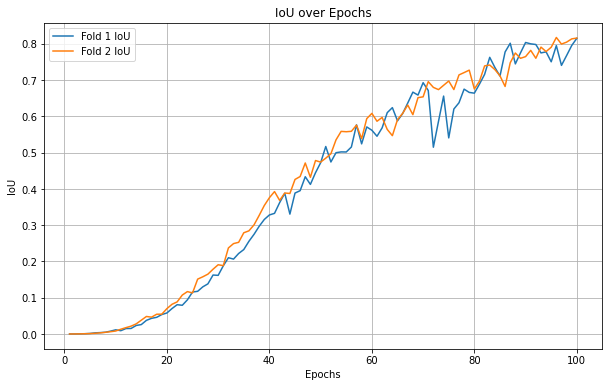

In [60]:
# Number of epochs
epochs = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))

# Plot val_iou for fold 1
plt.plot(epochs, histories[0]['iou'], label='Fold 1 IoU')

# Plot val_iou for fold 2
plt.plot(epochs, histories[1]['iou'], label='Fold 2 IoU')

# Adding title and labels
plt.title('IoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

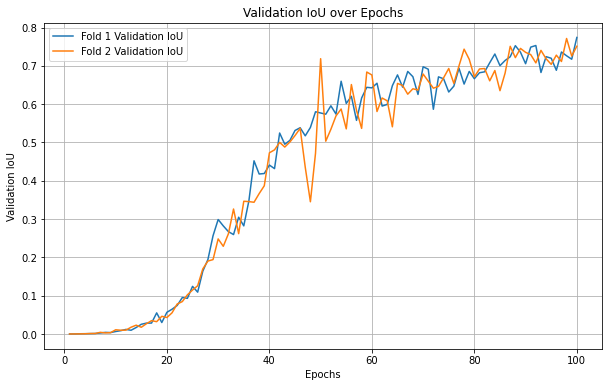

In [57]:
# Number of epochs
epochs = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))

# Plot val_iou for fold 1
plt.plot(epochs, histories[0]['val_iou'], label='Fold 1 Validation IoU')

# Plot val_iou for fold 2
plt.plot(epochs, histories[1]['val_iou'], label='Fold 2 Validation IoU')

# Adding title and labels
plt.title('Validation IoU over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation IoU')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

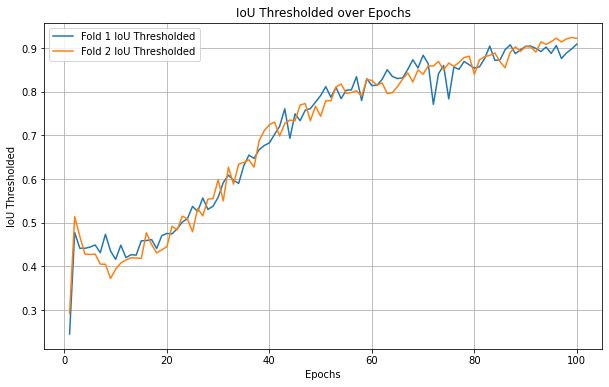

In [59]:
# Number of epochs
epochs = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))

# Plot val_iou for fold 1
plt.plot(epochs, histories[0]['iou_thresholded'], label='Fold 1 IoU Thresholded')

# Plot val_iou for fold 2
plt.plot(epochs, histories[1]['iou_thresholded'], label='Fold 2 IoU Thresholded')

# Adding title and labels
plt.title('IoU Thresholded over Epochs')
plt.xlabel('Epochs')
plt.ylabel('IoU Thresholded')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

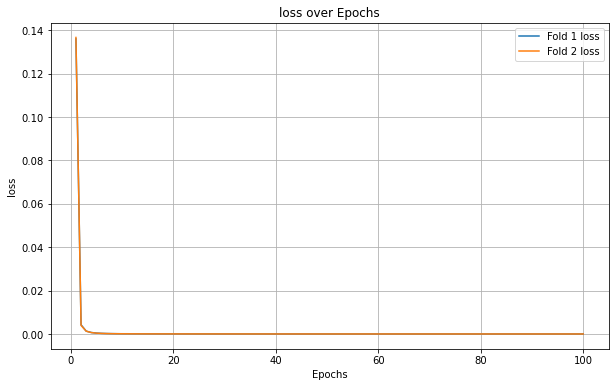

In [63]:
# Number of epochs
epochs = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))

# Plot val_iou for fold 1
plt.plot(epochs, histories[0]['loss'], label='Fold 1 loss')

# Plot val_iou for fold 2
plt.plot(epochs, histories[1]['loss'], label='Fold 2 loss')

# Adding title and labels
plt.title('loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

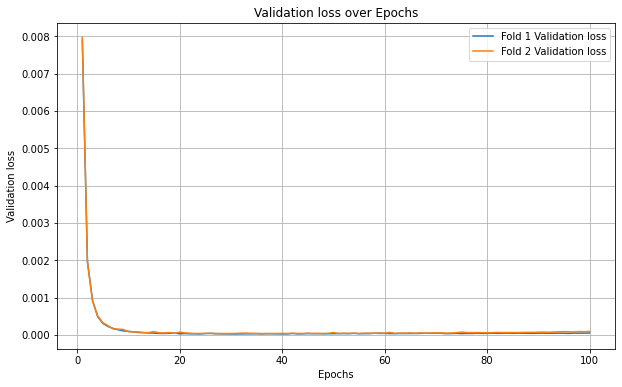

In [64]:
# Number of epochs
epochs = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))

# Plot val_iou for fold 1
plt.plot(epochs, histories[0]['val_loss'], label='Fold 1 Validation loss')

# Plot val_iou for fold 2
plt.plot(epochs, histories[1]['val_loss'], label='Fold 2 Validation loss')

# Adding title and labels
plt.title('Validation loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

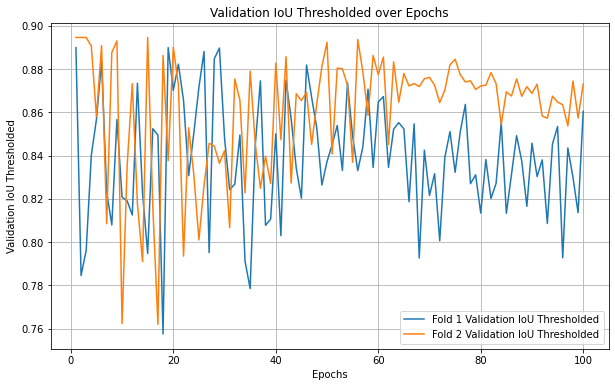

In [65]:
# Number of epochs
epochs = range(1, 101)

# Plotting
plt.figure(figsize=(10, 6))

# Plot val_iou for fold 1
plt.plot(epochs, histories[0]['val_iou_thresholded'], label='Fold 1 Validation IoU Thresholded')

# Plot val_iou for fold 2
plt.plot(epochs, histories[1]['val_iou_thresholded'], label='Fold 2 Validation IoU Thresholded')

# Adding title and labels
plt.title('Validation IoU Thresholded over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Validation IoU Thresholded')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

In [66]:
y_pred = C.Helper.prediction(test_images_array, model)

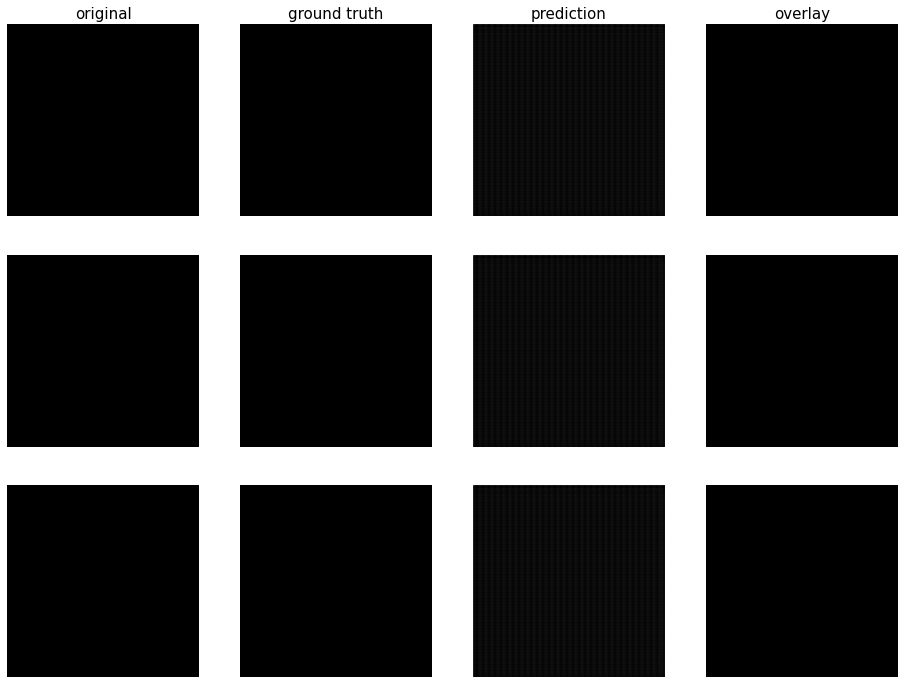

In [67]:
C.Helper.visualize_result(test_images_array, y_test, y_pred)

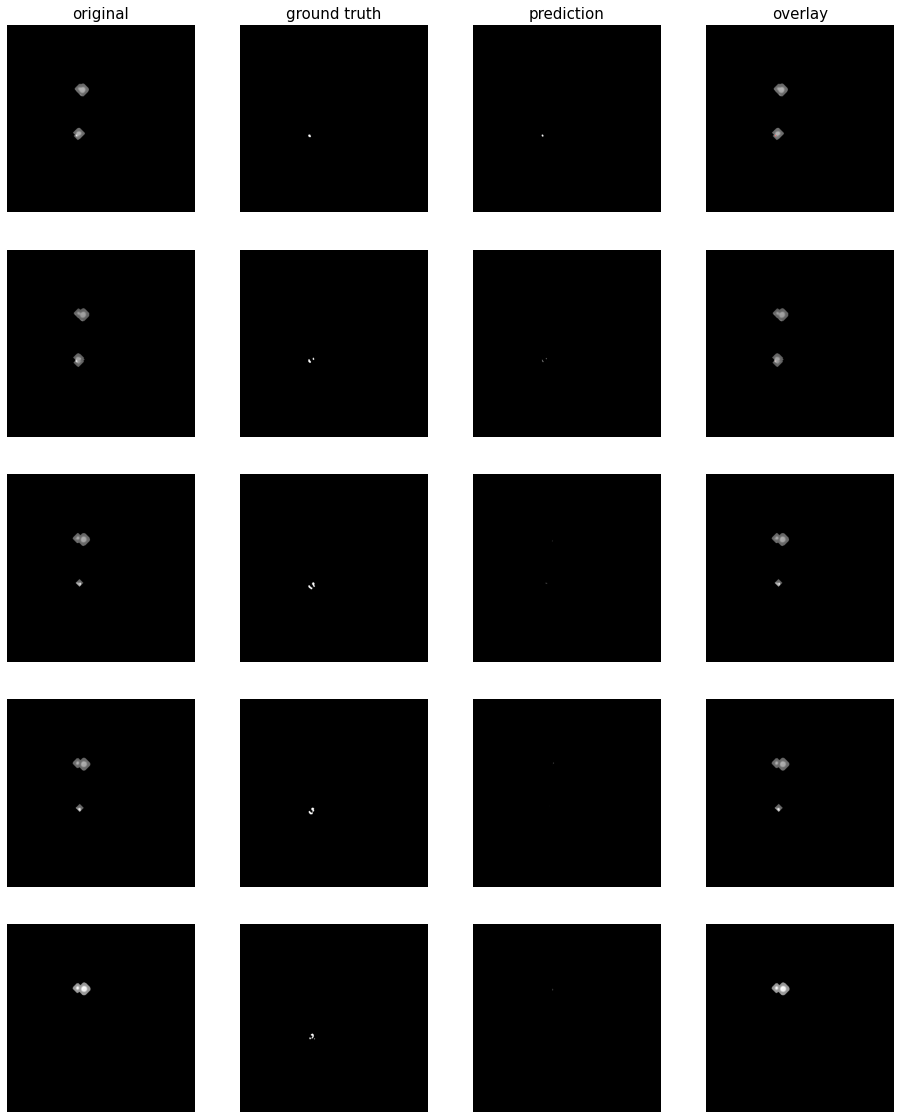

In [69]:
C.Helper.visualize_result_limit(test_images_array, y_test, y_pred, start_index=105, end_index=110)

In [70]:
C.Helper.evaluate(test_images_array, y_test, model)

105/105 [==============================] - 27s 257ms/step - loss: 1.0209e-04 - iou: 0.6247 - iou_thresholded: 0.8170


In [71]:
a = y_pred
a_binary = np.zeros(a.shape, dtype=np.bool_)
a_binary[a > 0.5] = True

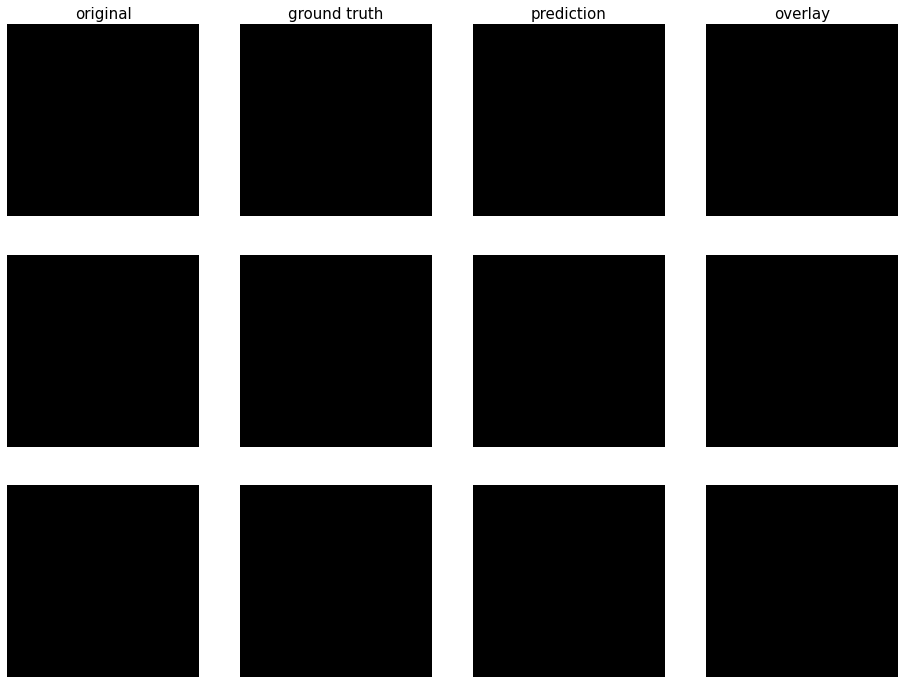

In [72]:
C.Helper.visualize_result(test_images_array, y_test, a_binary)

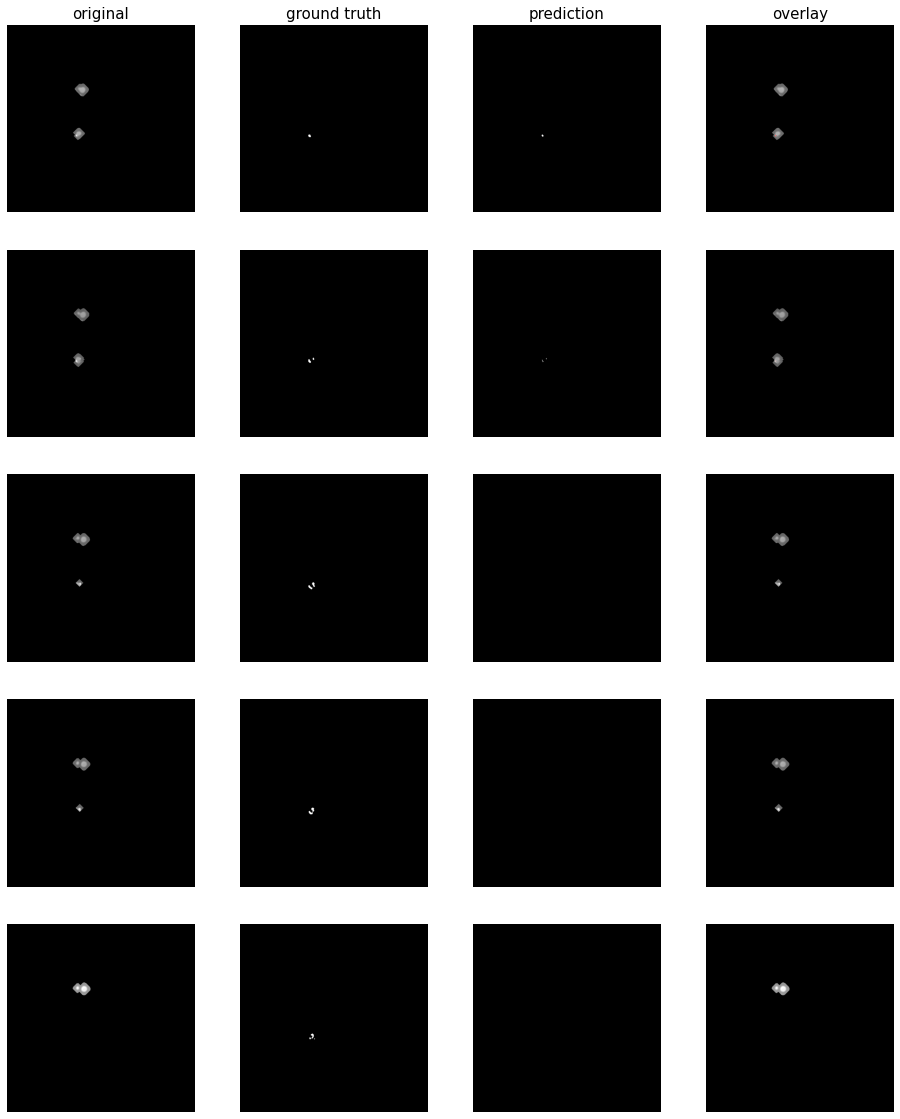

In [74]:
C.Helper.visualize_result_limit(test_images_array, y_test, a_binary, start_index=105, end_index=110)

In [75]:
C.Helper.evaluate(test_images_array, a_binary, model)

105/105 [==============================] - 27s 257ms/step - loss: 7.2465e-07 - iou: 0.7540 - iou_thresholded: 1.0000


In [76]:
experiment_data = {
    'slice_to_patient_mapping': slice_to_patient_mapping,
    'last_key': last_key,
    'predictions': y_pred,
    'y_pred_threshold': a_binary
}

In [77]:
experiment_data_path = '/raid/mpsych/CACTAS/DATA/HISTORY/unet_30/experiment_data.pkl'

In [78]:
with open(experiment_data_path, 'wb') as f:
    pickle.dump(experiment_data, f)

In [79]:
path = '/raid/mpsych/CACTAS/DATA/HISTORY/'

In [80]:
with open(path + 'unet_30/train_patient_order.pkl', 'rb') as f:
    train = pickle.load(f)

with open(path + 'unet_30/test_patient_order.pkl', 'rb') as f:
    test = pickle.load(f)
    
with open(path + 'unet_30/training_history.pkl', 'rb') as f:
    history = pickle.load(f)

with open(path + 'unet_30/experiment_data.pkl', 'rb') as f:
    data = pickle.load(f)

In [81]:
data['last_key']

10335